In [107]:
%matplotlib inline

import PIL
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [85]:
def get_radial_line_through_point(lon, lat, R=1, resolution=0.01, tmin=1, tmax=2):

    lon_rad, lat_rad = np.radians(lon), np.radians(lat)
    x = R * np.cos(lat_rad) * np.cos(lon_rad)
    y = R * np.cos(lat_rad) * np.sin(lon_rad)
    z = R * np.sin(lat_rad)
    
    t = np.arange(tmin, tmax + resolution, resolution)
    
    return x * t, y * t, z * t



def get_line_on_sphere(lon1, lat1, lon2, lat2, resolution=0.01, R=1):
    
    
    res = resolution * np.sign(lon2 - lon1)
    lons = np.radians([lon1 + i * res for i in range(int(abs(lon2 - lon1) // resolution) + 1)])

    res = resolution * np.sign(lat2 - lat1)
    lats = np.radians([lat1 + i * res for i in range(int(abs(lat2 - lat1) // resolution) + 1)])

    
    if len(lons) == 1:
        lons = np.ones_like(lats) * np.radians(lon1)
        
    if len(lats) == 1:
        lats = np.ones_like(lons) * np.radians(lat1)
    
    
    if len(lons) > len(lats):
        res = (lat2 - lat1) / (len(lons) - 1)
        lats = np.radians([lat1 + i * res for i in range(len(lons))])
    
    if len(lons) < len(lats):
        res = (lon2 - lon1) / (len(lons) - 1)
        lons = np.radians([lon1 + i * resolution for i in range(len(lats))])
    
    
    
    x = R * np.cos(lats) * np.cos(lons)
    y = R * np.cos(lats) * np.sin(lons)
    z = R * np.sin(lats)
    
    return x, y, z
    
    

def get_rectangle_on_sphere(ll_lon, ll_lat, ur_lon, ur_lat, resolution=0.01, R=1):
    
    line1 = get_line_on_sphere(ll_lon, ll_lat, ll_lon, ur_lat, R=R, resolution=resolution)
    line2 = get_line_on_sphere(ll_lon, ur_lat, ur_lon, ur_lat, R=R, resolution=resolution)
    line3 = get_line_on_sphere(ur_lon, ur_lat, ur_lon, ll_lat, R=R, resolution=resolution)
    line4 = get_line_on_sphere(ur_lon, ll_lat, ll_lon, ll_lat, R=R, resolution=resolution)
    
    lines = [line1, line2, line3, line4]
    x = []
    y = []
    z = []
    for edge in lines:
        x += list(edge[0])
        y += list(edge[1])
        z += list(edge[2])
        
    return x, y, z
    
    
    
    

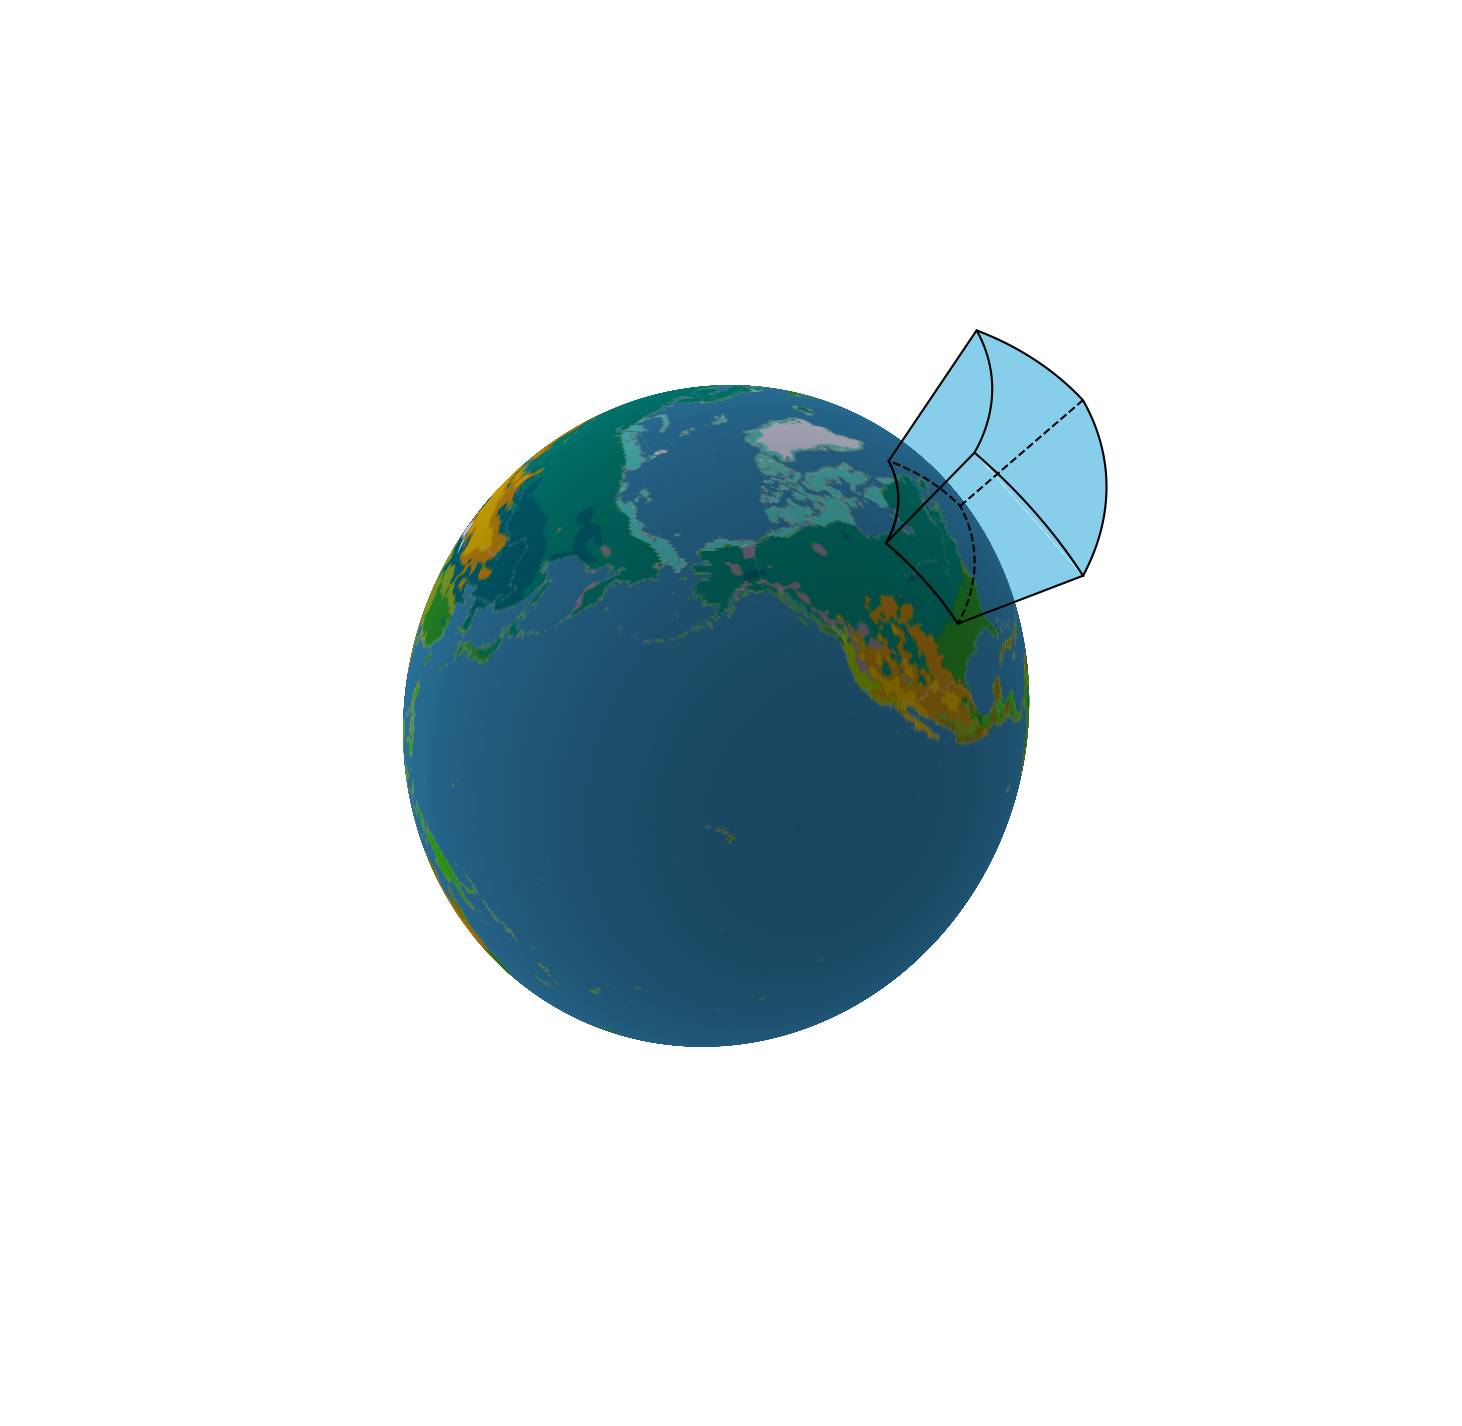

In [122]:


# load bluemarble with PIL
bm = PIL.Image.open('world_map.png')
# it's big, so I'll rescale it, convert to array, and divide by 256 to get RGB values that matplotlib accept 
bm = np.array(bm.resize([d for d in bm.size])) / 256.

# coordinates of the image - don't know if this is entirely accurate, but probably close
lons = np.linspace(-180, 180, bm.shape[1]) * np.pi/180 
lats = np.linspace(-90, 90, bm.shape[0])[::-1] * np.pi/180 

# repeat code from one of the examples linked to in the question, except for specifying facecolors:
fig = plt.figure(figsize=(6, 6), dpi=300)
ax = fig.add_subplot(111, projection='3d')

R = 0.5

x = R * np.outer(np.cos(lons), np.cos(lats)).T
y = R * np.outer(np.sin(lons), np.cos(lats)).T
z = R * np.outer(np.ones(np.size(lons)), np.sin(lats)).T
ax.plot_surface(x, y, z, rstride=2, cstride=2, facecolors = bm, zorder=-1, alpha=0.9)

ax.view_init(elev=40, azim=-160)
ax.set_axis_off()



linewidth = 0.5
ll_lon, ll_lat = -90, 35
ur_lon, ur_lat = -50, 55
tile_size_deg = 2
tmax = 1.5



# Fill in the front faces
# face1
face1 = []
face1.extend(list(zip(*get_line_on_sphere(ll_lon, ll_lat, ll_lon, ur_lat, R=R))))
face1.extend(list(zip(*get_radial_line_through_point(ll_lon, ur_lat, tmax=tmax, R=R))))
face1.extend(list(zip(*get_line_on_sphere(ll_lon, ll_lat, ll_lon, ur_lat, R=R * tmax))))
x, y, z = get_radial_line_through_point(ll_lon, ll_lat, tmax=tmax, R=R)
face1.extend(list(zip(x[::-1], y[::-1], z[::-1])))


face2 = []
face2.extend(list(zip(*get_line_on_sphere(ll_lon, ur_lat, ur_lon, ur_lat, R=R))))
face2.extend(list(zip(*get_radial_line_through_point(ur_lon, ur_lat, tmax=tmax, R=R))))
face2.extend(list(zip(*get_line_on_sphere(ur_lon, ur_lat, ll_lon, ur_lat, R=R * tmax))))
x, y, z = get_radial_line_through_point(ll_lon, ur_lat, tmax=tmax, R=R)
face2.extend(list(zip(x[::-1], y[::-1], z[::-1])))

face3 = []
face3.extend(list(zip(*get_line_on_sphere(ll_lon, ll_lat, ll_lon, ur_lat, R=R * tmax))))
face3.extend(list(zip(*get_line_on_sphere(ll_lon, ur_lat, ur_lon, ur_lat, R=R * tmax))))
face3.extend(list(zip(*get_line_on_sphere(ur_lon, ur_lat, ur_lon, ll_lat, R=R * tmax))))
face3.extend(list(zip(*get_line_on_sphere(ur_lon, ll_lat, ll_lon, ll_lat, R=R * tmax))))


ax.add_collection3d(Poly3DCollection([face1, face2, face3], alpha=1, zorder=100, facecolor="skyblue"))


# plot rectangle on a sphere
x, y, z = get_rectangle_on_sphere(ll_lon, ll_lat, ur_lon, ur_lat, R=R)
ax.plot(x, y, z, "k", linewidth=linewidth, linestyle="dashed")

x, y, z = get_line_on_sphere(ll_lon, ll_lat, ll_lon, ur_lat, R=R)
ax.plot(x, y, z, "k", linewidth=linewidth)

x, y, z = get_line_on_sphere(ll_lon, ur_lat, ur_lon, ur_lat, R=R)
ax.plot(x, y, z, "k", linewidth=linewidth)



x, y, z = get_rectangle_on_sphere(ll_lon, ll_lat, ur_lon, ur_lat, R=R * tmax)
ax.plot(x, y, z, "k", linewidth=linewidth)



# plot the radial lines
x, y, z = get_radial_line_through_point(ll_lon, ll_lat, tmax=tmax, R=R)
ax.plot(x, y, z, "k", linewidth=linewidth)

x, y, z = get_radial_line_through_point(ll_lon, ur_lat, tmax=tmax, R=R)
ax.plot(x, y, z, "k", linewidth=linewidth)

x, y, z = get_radial_line_through_point(ur_lon, ur_lat, tmax=tmax, R=R)
ax.plot(x, y, z, "k", linewidth=linewidth)

x, y, z = get_radial_line_through_point(ur_lon, ll_lat, tmax=tmax, R=R)
ax.plot(x, y, z, "k", linewidth=linewidth, linestyle="dashed")


plt.savefig("globe.png", bbox_inches="tight", transparent=True, dpi=200)




In [96]:
reversed([1,2,3])